In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math as m
%matplotlib inline


In [144]:
class Warehouse():
    def __init__(self):
        self.stores = []
        self.max_age = 4
        self.storage = np.zeros(self.max_age + 4)
        self.log = pd.DataFrame(columns=["Day", "storeId", "itemAge", "sumItem", "overBuy"])
        self.dayCount = 1

    def predict_order(self):

        # TODO: Implement prediction
        # max(0,store_avg_sum - sum_of_all_storage)
        # if theres more storage then expected we don't need to order
        return max(0, sum([store.avg for store in self.stores]) - sum([sum(store.storage) for store in self.stores]))

    def addStore(self, store):
        """
        Connect new store to the Warehouse
        """
        self.storage += store.avg
        self.stores.append(store)

    def one_day(self):
        """ 
        - Distribute by category favouring Stores at the beginning of queue.
        - A category is a group of items with the same age.
        - Because one Store can get items from multiple categories (it recieves a list)
        we build up the list with the supplied items for every store before
        it can be passed to the Stores.
        """

        # * RECIEVEING AND DISTRIBUTING
        order_builder = np.zeros(shape=(len(self.stores), self.max_age))
        order_sum = sum([x.ordered_amount for x in self.stores])  # get global order for warehouse
        index = 0

        
        """
        Creating array of items from categories until 
        Store got what they ordered 
        or Warehouse goes empty 
        """
        while (order_sum > 0 and sum(self.storage) > 0):
            if self.storage[index + 3] >= order_sum:
                for i, store in enumerate(self.stores):
                    order_builder[i][index] = store.ordered_amount

                    self.storage[index + 3] -= store.ordered_amount
                break
            else:
                for i, store in enumerate(self.stores):
                    
                    provided = m.floor(self.storage[index + 3] * (store.ordered_amount / order_sum))
                    order_builder[i][index] = provided
                    store.ordered_amount -= provided
                    order_sum -= provided

                # this iteration ensures to give out
                # the whole category and the usage of floor() 
                # can result in remaining items
                self.storage[index + 3] = 0
                
                #only go to next category if not enough storage
                index += 1
                if(index >= self.max_age):
                    break

        for i, store in enumerate(self.stores):
            store.one_day(order_builder[i])


        # TODO: give out order_builder, clear store orders
        # TODO: manage last item in storage as error?
        # TODO: remove sphagetti

        # * LOGGING
        for store in self.stores:
            new_row = {
                "Day": self.dayCount,
                "storeId": store.id,
                "itemAge": 0 if sum(store.storage)==0 else np.max(np.nonzero(store.storage)),
                # storage is never empty due to negative index errors
                "sumItem": sum(store.storage),
                "overBuy": -store.overbuy}
            self.log.loc[len(self.log.index)] = new_row

        # * PREPARATIONS
        self.storage = np.roll(self.storage, 1)
        # save expired item amount
        # self.expired = self.storage[0]
        self.storage[0] = self.predict_order()
        self.dayCount += 1
       

    def simulate_days(self, days):

        for _ in range(days):
            self.one_day()


class Store():
    def __init__(self, avg_range, std_range, id, max_age=4):

        # ? with rangeifying the distribution
        # ? the Store order identifier can be the current day's average or the next day's average

        # TODO: minimum storage amount at end

        self.id = id
        self.avg_range = avg_range
        self.std_range = std_range

        self.max_age = max_age
        self.avg = 0
        self.std = 0
        self.overbuy = 0

        # start with empty storage and order average for fillup
        self.ordered_amount = self.avg
        self.expired = 0
        self.storage = np.zeros(self.max_age)

    def get_sold_amount(self):
        """
        Create variance in daily distribution by picking random for the average and deviation
        """

        # update distribution for current day
        self.avg = np.random.choice(self.avg_range)
        self.std = np.random.choice(self.std_range)

        # return bought amount for the day
        return max(0,round(np.random.normal(self.avg, self.std, 1)[0], 0))

    def update_storage(self):
        """
        Subtract demand from storage and return the supply-demand difference
        """
        # get daily demand amount from distribution
        bought_amount = self.get_sold_amount()

        # rolling subtraction of demand from storage
        for index in range(self.max_age):
            bought_amount -= self.storage[index]
            if (bought_amount >= 0):
                self.storage[index] = 0
            else:
                self.storage[index] = (-1) * bought_amount
                bought_amount = 0
                break

        # get too old items
        # shift storage by one day
        self.expired = self.storage[self.max_age - 1]
        self.storage = np.roll(self.storage, 1)
        self.storage[-1] = 0

        return bought_amount

    def one_day(self, received: np.ndarray):

        """
        Simulate one day for the Store
        recieving supply
        update storage for the demand of the day
        place new order
        """
        #reshaping recieved array, and adding it to storage

        reshaped = np.zeros(self.max_age)
        reshaped[:len(received)] = received
        
        self.storage += reshaped

        # process supply and demand
        self.overbuy = self.update_storage()

        # calculate order for next day
        self.ordered_amount = self.avg - sum(self.storage)
        
        if (self.ordered_amount < 0):
            self.ordered_amount = 0

In [145]:
w = Warehouse()
w.addStore(Store(
    avg_range=[8,9,10,11,12],
    std_range=[4,5,6,7],
    id=1))

In [146]:
w.simulate_days(300)

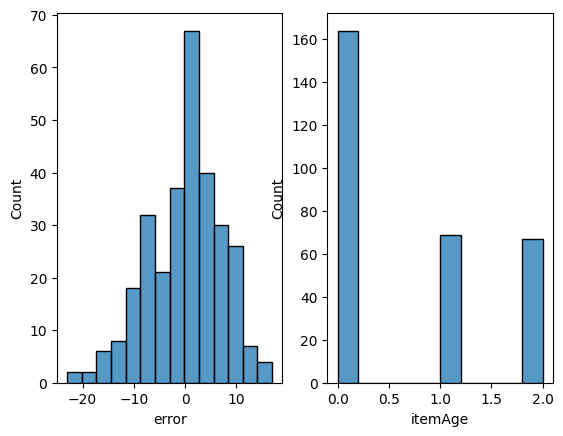

In [147]:
fig, axes = plt.subplots(1,2)
w.log["error"] = w.log.apply(lambda x: x.overBuy+x.sumItem,axis=1)
sns.histplot(data=w.log,x="error",ax=axes[0])
sns.histplot(data=w.log,x="itemAge",ax=axes[1])
plt.show()

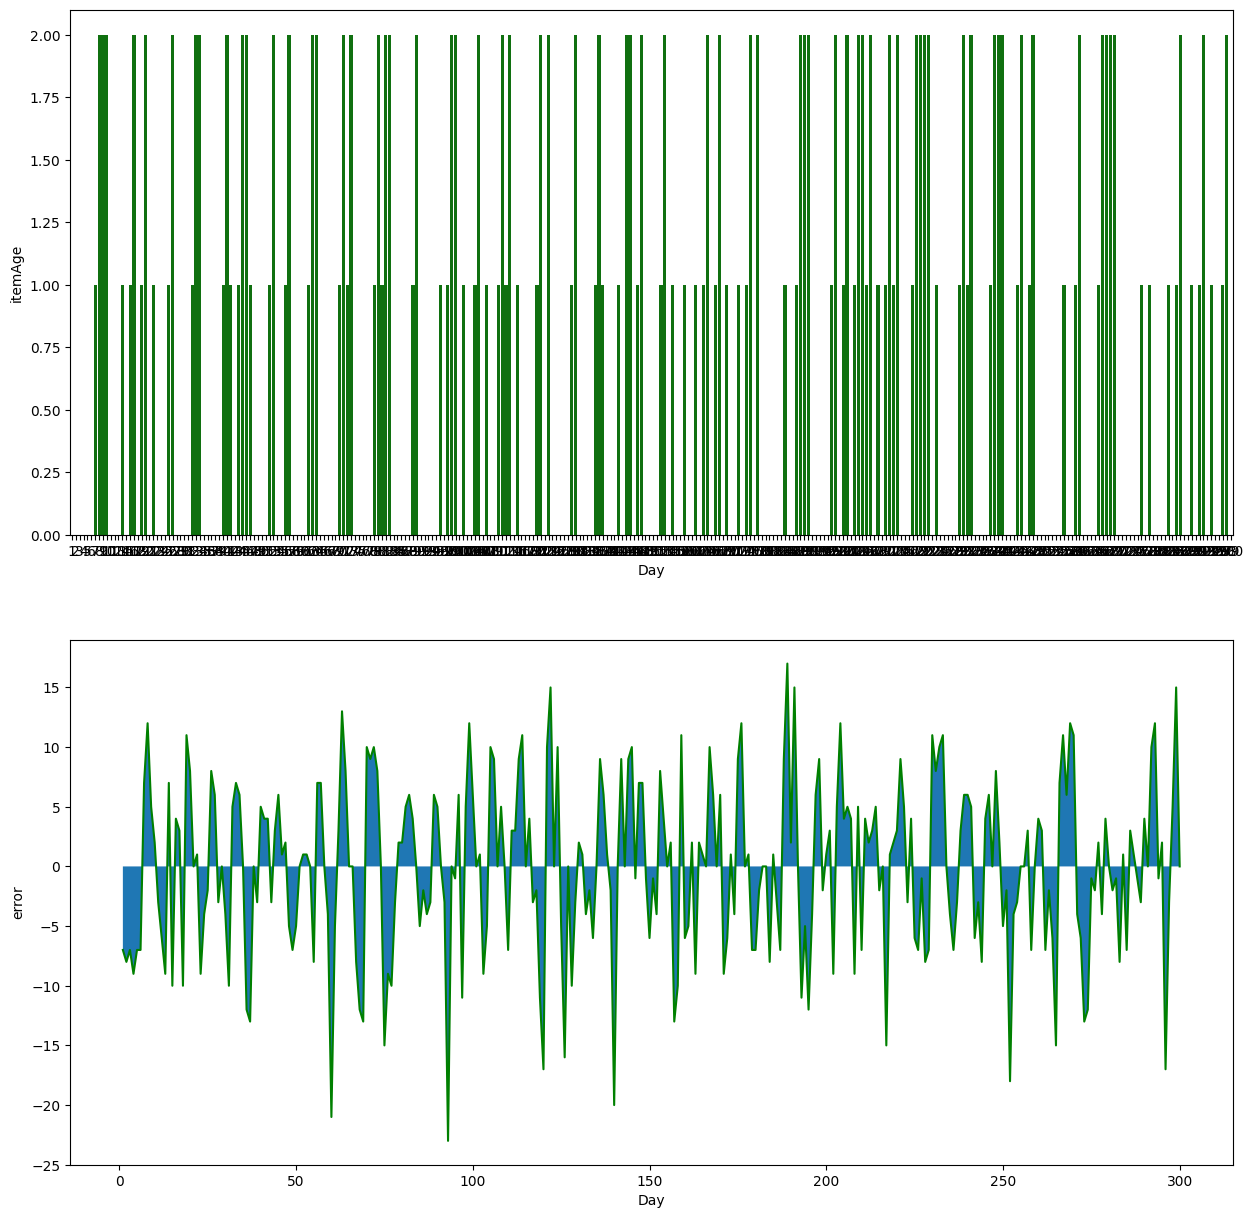

In [148]:
fig, axes = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
sns.barplot(data=w.log,x="Day",y="itemAge",color="green", ax= axes[0])
#sns.barplot(data=w.log,x="Day",y="overBuy",color="red", ax= axes[1])
#sns.barplot(data=w.log,x ="Day", y="sumItem",color="green", ax= axes[1])
w.log["error"] = w.log["overBuy"] + w.log["sumItem"]
sns.lineplot(data=w.log,x ="Day", y="error",color="green", ax= axes[1])
plt.fill_between(w.log["Day"],w.log["error"],interpolate=True)

plt.show()

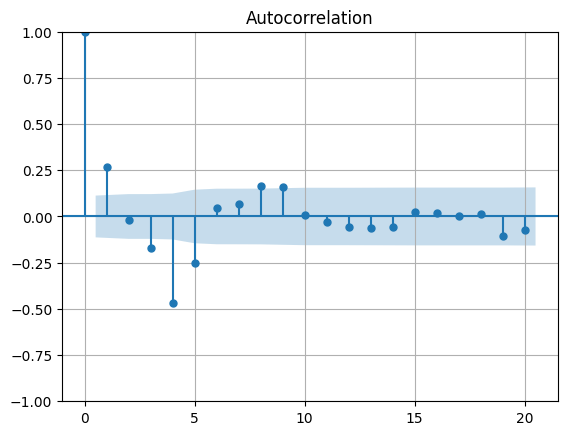

In [149]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_acf(w.log["error"],lags=20);
#plt.xticks(np.arange(0, 50+1, 5.0))

plt.grid(True)